## Homework 4

Use this notebook as a starter

In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [ ]:
!curl https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv -o ../data/CreditScoring.csv
    

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [25]:
df = pd.read_csv('../data/CreditScoring.csv')
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Some of the features are encoded as numbers. Use the following code to de-code them:

In [26]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [27]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [28]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [29]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [30]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['home', 'marital', 'records', 'job']

In [31]:
numerical = list(df.dtypes[df.dtypes == 'int64'].index)
numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price',
 'default']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [32]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [50]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

dv = DictVectorizer(sparse=False)

In [54]:
for c in numerical:
    if c != 'default':
        train_dict = pd.DataFrame(df_train[c]).to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        val_dict = pd.DataFrame(df_val[c]).to_dict(orient='records')
        X_val = dv.transform(val_dict)

        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_val, y_pred)

        print(c, round(auc(fpr, tpr), 4))

seniority 0.6903
time 0.5529
age 0.5592
expenses 0.5126
income 0.664
assets 0.6017
debt 0.5076
amount 0.5884
price 0.4663


Which numerical variable (among the following 4) has the highest AUC?

- seniority (X)
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [58]:
feat_cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']
train_dict = df_train[feat_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[feat_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812 X

In [60]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
print("Answer:", round(auc(fpr, tpr), 3))

Answer: 0.812


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [75]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    df_scores['prec'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
        
    return df_scores

In [76]:
df_scores = precision_recall_dataframe(y_val, y_pred)
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,prec,recall
0,0.00,246,645,0,0,1.00000,1.000000,0.276094,1.00000
1,0.01,246,635,0,10,1.00000,0.984496,0.279228,1.00000
2,0.02,244,613,2,32,0.99187,0.950388,0.284714,0.99187
3,0.03,242,593,4,52,0.98374,0.919380,0.289820,0.98374
4,0.04,242,563,4,82,0.98374,0.872868,0.300621,0.98374
...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,246,645,0.00000,0.000000,NaN,0.00000
97,0.97,0,0,246,645,0.00000,0.000000,NaN,0.00000
98,0.98,0,0,246,645,0.00000,0.000000,NaN,0.00000
99,0.99,0,0,246,645,0.00000,0.000000,NaN,0.00000


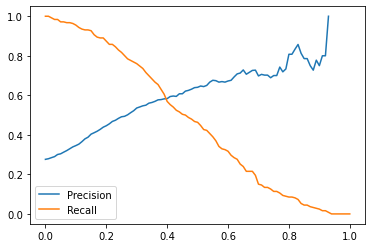

In [77]:
plt.plot(df_scores.threshold, df_scores['prec'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4 X
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [86]:
F1 = 2 * df_scores['prec'] * df_scores['recall'] / (df_scores['prec'] + df_scores['recall'])
df_F1 = pd.DataFrame({'Threshold': np.linspace(0, 1, 101), 'F1': F1})
df_F1

,Threshold,F1
0,0.00,0.432718
1,0.01,0.436557
2,0.02,0.442430
3,0.03,0.447734
4,0.04,0.460514
...,...,...
96,0.96,NaN
97,0.97,NaN
98,0.98,NaN
99,0.99,NaN


In [87]:
df_F1[df_F1.F1 == max(df_F1.F1)]

,Threshold,F1
30,0.3,0.628571


At which threshold F1 is maximal?

- 0.1
- 0.3 X
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [102]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

In [103]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv = DictVectorizer(sparse=False)
    train_dict = df_train[feat_cols].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[feat_cols].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    del df_train['default']
    del df_val['default']

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]    
    
    scores.append(roc_auc_score(y_val, y_pred))

scores

[0.8256212256212256,
 0.8254077031563476,
 0.7893383818254285,
 0.8250108084738436,
 0.8054696294614563]

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014 X
- 0.09
- 0.14

In [105]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.814 +- 0.015


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [107]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv = DictVectorizer(sparse=False)
        train_dict = df_train[feat_cols].to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        val_dict = df_val[feat_cols].to_dict(orient='records')
        X_val = dv.transform(val_dict)

        del df_train['default']
        del df_val['default']

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]    

        scores.append(roc_auc_score(y_val, y_pred))

    print('C=%s %.4f +- %.4f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.8077 +- 0.0118
C=0.1 0.8129 +- 0.0137
C=1 0.8142 +- 0.0146
C=10 0.8141 +- 0.0146



Which C leads to the best mean score?

- 0.01
- 0.1
- 1 X
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.